In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt

 
plt.style.use(['science','notebook'])
plt.style.reload_library()

In [3]:
from june import World 
from june.geography import Geography
from june.demography import Demography
from june.interaction import Interaction
from june.infection import Infection, InfectionSelector
from june.infection.health_index import Data2Rates
from june.infection.health_index.health_index import HealthIndexGenerator
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries
from june.groups.travel import *
from june.simulator import Simulator
from june.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.records import Record, RecordReader

from june.world import generate_world_from_geography
from june.hdf5_savers import generate_world_from_hdf5

No --data argument given - defaulting to:
/home/florpi/JUNE/data
No --configs argument given - defaulting to:
/home/florpi/JUNE/june/configs
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [4]:
CONFIG_PATH = paths.configs_path / "config_example.yaml"

In [5]:
%%time 

geography = Geography.from_file(
{
    "super_area": ["E02001731", "E02002566",
                   "E02004935","E02000134",
                   "E02004987", "E02004933",
                  "E02004938", "E02004989", 
                  "E02004991", "E02004990",
                  "E02004992", "E02004942",
                  "E02004856", "E02003651",
                  "E02004931", "E02004926",
                  "E02004925", "E02004924"
                  "E02001897","E02001903"]
}
)

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
#geography.universities = Universities.for_super_areas(geography.super_areas)
world = generate_world_from_geography(geography, include_households=True)


2020-11-30 21:12:56,472 - june.geography.geography - INFO - There are 437 areas and 18 super_areas and 4 in the world.
2020-11-30 21:12:56,480 - hospitals - INFO - There are 1 hospitals in this geography.
2020-11-30 21:12:56,541 - schools - INFO - There are 64 schools in this geography.
2020-11-30 21:12:56,686 - schools - INFO - No school for the age 0 in this world.
2020-11-30 21:12:56,690 - schools - INFO - No school for the age 1 in this world.
2020-11-30 21:12:57,147 - care_homes - INFO - There are 35 care_homes in this geography.
2020-11-30 21:13:05,645 - world - INFO - Populating areas
2020-11-30 21:13:07,301 - world - INFO - Areas populated. This world's population is: 138609
2020-11-30 21:13:10,671 - worker_distributor - INFO - Distributing workers to super areas...
2020-11-30 21:13:17,264 - worker_distributor - INFO - Workers distributed.
2020-11-30 21:13:18,443 - care_home_distributor - INFO - Populating care homes
2020-11-30 21:13:18,466 - care_home_distributor - INFO - This

## Commute, travel and leisure

In [6]:
%%time

world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_areas(
    areas=world.areas, super_areas=world.super_areas
)


2020-11-30 21:13:43,735 - social_venue - INFO - Domain 0 has 17580 pubs(s)
2020-11-30 21:13:43,870 - social_venue - INFO - Domain 0 has 78 cinemas(s)
2020-11-30 21:13:46,029 - social_venue - INFO - Domain 0 has 4554 groceries(s)
2020-11-30 21:13:46,068 - leisure - INFO - Linking households for visits
2020-11-30 21:13:47,597 - leisure - INFO - Done
2020-11-30 21:13:47,598 - leisure - INFO - Linking households with care homes for visits
2020-11-30 21:13:47,866 - leisure - INFO - Done
2020-11-30 21:13:47,868 - leisure - INFO - Distributing social venues to areas
2020-11-30 21:13:47,871 - leisure - INFO - Distributed in 0 of 437 areas.
2020-11-30 21:13:49,054 - leisure - INFO - Distributed in 437 of 437 areas.
CPU times: user 13.6 s, sys: 61 ms, total: 13.6 s
Wall time: 13.8 s


In [7]:
# initialise commuting travel
travel = Travel()
travel.initialise_commute(world)

2020-11-30 21:13:49,133 - travel - INFO - Initialising commute...
2020-11-30 21:13:49,142 - travel - INFO - Creating cities...
2020-11-30 21:13:49,180 - travel - INFO - This world has 5 cities, with names
['London', 'Newcastle upon Tyne', 'Birmingham', 'Darlington', 'St Albans']
2020-11-30 21:13:49,182 - travel - INFO - Determining people mode of transport
2020-11-30 21:14:01,075 - travel - INFO - Mode of transport allocated in 0 of 437 areas.
2020-11-30 21:14:01,425 - travel - INFO - Mode of transport determined for everyone.
2020-11-30 21:14:01,713 - travel - INFO - Assigning commuters to stations...
2020-11-30 21:14:01,714 - travel - INFO - Assigned 0 of 138609 potential commuters...
2020-11-30 21:14:01,788 - travel - INFO - Commuters assigned
2020-11-30 21:14:01,789 - travel - INFO - City London has 350 internal and 568 external commuters.
2020-11-30 21:14:01,790 - travel - INFO - City Newcastle upon Tyne has 863 internal and 736 external commuters.
2020-11-30 21:14:01,792 - travel

We are also going to need some cemeteries...


In [8]:
world.cemeteries = Cemeteries()

In [9]:
import random

In [10]:
for person in world.people:
    person.sex = random.choice(['m','f'])
    person.age = np.random.randint(0,100)

### If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later.

In [11]:
world.to_hdf5("world.hdf5")

2020-11-30 21:14:03,064 - world_saver - INFO - saving world to HDF5
2020-11-30 21:14:03,168 - world_saver - INFO - saving population...
2020-11-30 21:14:08,979 - world_saver - INFO - saving hospitals...
2020-11-30 21:14:08,985 - world_saver - INFO - saving schools...
2020-11-30 21:14:09,006 - world_saver - INFO - saving companies...
2020-11-30 21:14:09,051 - world_saver - INFO - saving households...
2020-11-30 21:14:10,399 - world_saver - INFO - saving care homes...
2020-11-30 21:14:10,407 - world_saver - INFO - saving cities...
2020-11-30 21:14:10,414 - world_saver - INFO - saving stations...
2020-11-30 21:14:10,421 - world_saver - INFO - saving social venues...


If we would like to load the world we saved, we just do

In [12]:
world = generate_world_from_hdf5("world.hdf5")

2020-11-30 21:14:10,580 - world_saver - INFO - loading world from HDF5
2020-11-30 21:14:10,603 - world_saver - INFO - loading hospitals...
2020-11-30 21:14:10,614 - world_saver - INFO - loading schools...
2020-11-30 21:14:10,639 - company_saver - INFO - loading companies...
2020-11-30 21:14:10,643 - company_saver - INFO - Companies chunk 0 of 1
2020-11-30 21:14:10,828 - world_saver - INFO - loading care homes...
2020-11-30 21:14:10,844 - world_saver - INFO - loading cities...
2020-11-30 21:14:10,851 - world_saver - INFO - loading stations...
2020-11-30 21:14:10,869 - household_saver - INFO - loading households...
2020-11-30 21:14:10,871 - household_saver - INFO - Loaded chunk 0 of 1
2020-11-30 21:14:12,087 - population saver - INFO - loading population...
2020-11-30 21:14:12,088 - population saver - INFO - Loaded chunk 0 of 1
2020-11-30 21:14:13,805 - world_saver - INFO - loading social venues...
2020-11-30 21:14:13,810 - social_venue - INFO - Domain 0 has 78 cinemas(s)
2020-11-30 21:1

In [13]:
# and regenerate leisure in case we load it externally
leisure = generate_leisure_for_config(world, CONFIG_PATH)
# create travel as well
travel = Travel()

you have now a beautiful pre-pandemic world. 

# Adding the infection

The module in charge of infecting people is called the ``InfectionSelector``, which gives people a transmission time profile and a symptoms trajectory based on their age and sex (through the health index generator)

In [14]:
data_to_rates = Data2Rates.from_file()
selector = InfectionSelector.from_file(
        data_to_rates=data_to_rates,
        transmission_config_path=paths.configs_path / 'defaults/transmission/XNExp.yaml'
)

2020-11-30 21:14:19,658 - rates - WARNING - Your age intervals do not contain values smaller than 18.We will presume ages from 0 to 18 all have the same value.
2020-11-30 21:14:19,661 - rates - WARNING - Your age intervals contain values larger than 99.Setting that to the be the uper limit
2020-11-30 21:14:19,669 - rates - WARNING - Your age intervals contain values larger than 99.Setting that to the be the uper limit
2020-11-30 21:14:19,674 - rates - WARNING - Your age intervals contain values larger than 99.Setting that to the be the uper limit
2020-11-30 21:14:19,679 - rates - WARNING - Your age intervals contain values larger than 99.Setting that to the be the uper limit
2020-11-30 21:14:19,685 - rates - WARNING - Your age intervals contain values larger than 99.Setting that to the be the uper limit
2020-11-30 21:14:19,704 - rates - WARNING - Your age intervals contain values larger than 99.Setting that to the be the uper limit


# Adding the interaction

In [15]:
interaction = Interaction.from_file(population=world.people)

Beta are the intensities of the interaction taking place at the different groups

In [16]:
interaction.beta

{'box': 1,
 'pub': 0.42941,
 'grocery': 0.04137,
 'cinema': 0.157461,
 'city_transport': 0.107969,
 'inter_city_transport': 0.383,
 'hospital': 0.1168,
 'care_home': 0.28,
 'company': 0.371,
 'school': 0.07,
 'household': 0.208,
 'university': 0.306}

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [17]:
interaction.alpha_physical

2.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [18]:
infection_seed = InfectionSeed(
    world, selector,
)

In [19]:
n_cases = len(world.people)
infection_seed.unleash_virus(
    population=world.people,
    n_cases=n_cases) # play around with the initial number of cases

# Set policies

In [20]:
policies = Policies.from_file()

We can have a look at one of the policies

In [21]:
print(policies.individual_policies[1].__dict__)

{'spec': 'limit_long_commute', 'start_time': datetime.datetime(1000, 1, 1, 0, 0), 'end_time': datetime.datetime(9999, 1, 1, 0, 0), 'policy_type': 'individual', 'policy_subtype': 'skip_activity', 'activities_to_remove': ['primary_activity', 'commute'], 'going_to_work_probability': 0.2}


# Run the simulation

The simulator is the main module in charge of running the simulation. It coordinates the ``ActivityManager`` which is responsible of allocating people to the right groups given the current timestep, it updates the health status of the population, and it runs the interaction over the different groups. All of these modules can be modified by policies at any given time.

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [22]:
record = Record(    
    record_path = 'results',    
    record_static_data=True,
) 

In [23]:
record.static_data(world=world)

In [24]:
simulator = Simulator.from_file(
    world=world,
    infection_selector=selector,
    interaction=interaction, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    travel = travel,
    record=record,
    policies = policies
)

In [25]:
%%time
simulator.run()

2020-11-30 21:15:53,579 - simulator - INFO - Starting simulation for 130 days at day 2020-03-01 00:00:00, to run for 130 days
2020-11-30 21:15:54,595 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:15:56,535 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 7.376002031378448e-06,6.198883056640625e-06 - 2020-03-01 00:00:00
2020-11-30 21:15:56,582 - simulator - INFO - Info for rank 0, Date = 2020-03-01 00:00:00, number of deaths =  0, number of infected = 138609
2020-11-30 21:15:57,375 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0003075130080105737,0.0003070831298828125 - 2020-03-01 00:00:00
2020-11-30 21:15:59,107 - simulator - INFO - CMS: Timestep for rank 0/1 - 4.510988188005285, 4.51098895072937 - 2020-03-01 00:00:00

2020-11-30 21:15:59,108 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:16:01,120 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.187008693814278e-06,5.

2020-11-30 21:16:37,986 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:16:40,182 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.964000592939556e-06,5.245208740234375e-06 - 2020-03-03 10:00:00
2020-11-30 21:16:40,251 - simulator - INFO - Info for rank 0, Date = 2020-03-03 10:00:00, number of deaths =  1, number of infected = 138608
2020-11-30 21:16:41,297 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0002771989966277033,0.00027680397033691406 - 2020-03-03 10:00:00
2020-11-30 21:16:43,563 - simulator - INFO - CMS: Timestep for rank 0/1 - 5.57448733599449, 5.574487209320068 - 2020-03-03 10:00:00

2020-11-30 21:16:43,564 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:16:44,363 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.801012204959989e-06,5.9604644775390625e-06 - 2020-03-03 13:00:00
2020-11-30 21:16:44,421 - simulator - INFO - Info for rank 0, Date = 2020-03-03 13

2020-11-30 21:17:29,778 - simulator - INFO - Info for rank 0, Date = 2020-03-06 00:00:00, number of deaths =  29, number of infected = 138580
2020-11-30 21:17:30,609 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00023594200320076197,0.00023555755615234375 - 2020-03-06 00:00:00
2020-11-30 21:17:32,660 - simulator - INFO - CMS: Timestep for rank 0/1 - 4.054269636995741, 4.0542707443237305 - 2020-03-06 00:00:00

2020-11-30 21:17:32,662 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:17:34,441 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.485002136789262e-06,3.814697265625e-06 - 2020-03-06 01:00:00
2020-11-30 21:17:34,515 - simulator - INFO - Info for rank 0, Date = 2020-03-06 01:00:00, number of deaths =  32, number of infected = 138577
2020-11-30 21:17:35,529 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0003359969996381551,0.00033545494079589844 - 2020-03-06 01:00:00
2020-11-30 21:17:37,412 - simulator

2020-11-30 21:18:25,653 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00023500999668613076,0.00023436546325683594 - 2020-03-08 12:00:00
2020-11-30 21:18:27,515 - simulator - INFO - CMS: Timestep for rank 0/1 - 3.7962060179997934, 3.7962069511413574 - 2020-03-08 12:00:00

2020-11-30 21:18:27,517 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:18:28,541 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 6.246002158150077e-06,5.4836273193359375e-06 - 2020-03-09 00:00:00
2020-11-30 21:18:28,600 - simulator - INFO - Info for rank 0, Date = 2020-03-09 00:00:00, number of deaths =  317, number of infected = 138292
2020-11-30 21:18:29,518 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00025451301189605147,0.0002541542053222656 - 2020-03-09 00:00:00
2020-11-30 21:18:31,282 - simulator - INFO - CMS: Timestep for rank 0/1 - 3.7638174280000385, 3.7638185024261475 - 2020-03-09 00:00:00

2020-11-30 21:18:31,285 - simulator

2020-11-30 21:19:14,672 - simulator - INFO - CMS: Timestep for rank 0/1 - 4.1600215859944, 4.160022258758545 - 2020-03-11 01:00:00

2020-11-30 21:19:14,673 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:19:15,711 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.3910043789073825e-06,4.76837158203125e-06 - 2020-03-11 09:00:00
2020-11-30 21:19:15,784 - simulator - INFO - Info for rank 0, Date = 2020-03-11 09:00:00, number of deaths =  859, number of infected = 137750
2020-11-30 21:19:16,656 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00018132198601961136,0.00018072128295898438 - 2020-03-11 09:00:00
2020-11-30 21:19:18,533 - simulator - INFO - CMS: Timestep for rank 0/1 - 3.858839041000465, 3.858839511871338 - 2020-03-11 09:00:00

2020-11-30 21:19:18,535 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:19:20,762 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.89199771638

2020-11-30 21:20:03,516 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:20:04,565 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 7.239999831654131e-06,6.67572021484375e-06 - 2020-03-13 13:00:00
2020-11-30 21:20:04,640 - simulator - INFO - Info for rank 0, Date = 2020-03-13 13:00:00, number of deaths =  1532, number of infected = 137047
2020-11-30 21:20:05,576 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00022678398818243295,0.0002262592315673828 - 2020-03-13 13:00:00
2020-11-30 21:20:07,361 - simulator - INFO - CMS: Timestep for rank 0/1 - 3.84439564900822, 3.84439754486084 - 2020-03-13 13:00:00

2020-11-30 21:20:07,362 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:20:09,607 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 7.441005436703563e-06,6.198883056640625e-06 - 2020-03-14 00:00:00
2020-11-30 21:20:09,683 - simulator - INFO - Info for rank 0, Date = 2020-03-14 00

2020-11-30 21:21:04,313 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.678993718698621e-06,4.0531158447265625e-06 - 2020-03-16 10:00:00
2020-11-30 21:21:04,388 - simulator - INFO - Info for rank 0, Date = 2020-03-16 10:00:00, number of deaths =  2574, number of infected = 133496
2020-11-30 21:21:05,331 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00021082600869704038,0.0002105236053466797 - 2020-03-16 10:00:00
2020-11-30 21:21:06,806 - simulator - INFO - CMS: Timestep for rank 0/1 - 6.332660767991911, 6.332661390304565 - 2020-03-16 10:00:00

2020-11-30 21:21:06,806 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:21:08,748 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.259993486106396e-06,4.5299530029296875e-06 - 2020-03-16 13:00:00
2020-11-30 21:21:08,802 - simulator - INFO - Info for rank 0, Date = 2020-03-16 13:00:00, number of deaths =  2613, number of infected = 132872
2020-11-30 21:21:09,546 - sim

2020-11-30 21:22:05,378 - simulator - INFO - Info for rank 0, Date = 2020-03-19 00:00:00, number of deaths =  3377, number of infected = 115445
2020-11-30 21:22:06,418 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0001907030091388151,0.0001900196075439453 - 2020-03-19 00:00:00
2020-11-30 21:22:08,242 - simulator - INFO - CMS: Timestep for rank 0/1 - 6.387707330999547, 6.387708425521851 - 2020-03-19 00:00:00

2020-11-30 21:22:08,243 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:22:11,382 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.665002390742302e-06,5.245208740234375e-06 - 2020-03-19 01:00:00
2020-11-30 21:22:11,451 - simulator - INFO - Info for rank 0, Date = 2020-03-19 01:00:00, number of deaths =  3393, number of infected = 115133
2020-11-30 21:22:12,379 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00020742199558299035,0.0002067089080810547 - 2020-03-19 01:00:00
2020-11-30 21:22:13,941 - simul

2020-11-30 21:23:14,172 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00023727200459688902,0.0002372264862060547 - 2020-03-21 08:00:00
2020-11-30 21:23:15,649 - simulator - INFO - CMS: Timestep for rank 0/1 - 6.422418418005691, 6.422421455383301 - 2020-03-21 08:00:00

2020-11-30 21:23:15,652 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:23:18,172 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.883004632778466e-06,5.245208740234375e-06 - 2020-03-21 12:00:00
2020-11-30 21:23:18,217 - simulator - INFO - Info for rank 0, Date = 2020-03-21 12:00:00, number of deaths =  4043, number of infected = 101155
2020-11-30 21:23:19,091 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.0009812689968384802,0.0009839534759521484 - 2020-03-21 12:00:00
2020-11-30 21:23:20,471 - simulator - INFO - CMS: Timestep for rank 0/1 - 4.811213223001687, 4.81121826171875 - 2020-03-21 12:00:00

2020-11-30 21:23:20,473 - simulator - INFO

2020-11-30 21:24:17,679 - simulator - INFO - CMS: Timestep for rank 0/1 - 5.216207696998026, 5.216208219528198 - 2020-03-24 01:00:00

2020-11-30 21:24:17,681 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:24:20,032 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.802001058124006e-06,4.0531158447265625e-06 - 2020-03-24 09:00:00
2020-11-30 21:24:20,079 - simulator - INFO - Info for rank 0, Date = 2020-03-24 09:00:00, number of deaths =  4545, number of infected = 65457
2020-11-30 21:24:20,898 - simulator - INFO - CMS: Infection COMS-v2 for rank 0/1(2) 0.00021008099429309368,0.00021028518676757812 - 2020-03-24 09:00:00
2020-11-30 21:24:22,096 - simulator - INFO - CMS: Timestep for rank 0/1 - 4.414189125003759, 4.414190053939819 - 2020-03-24 09:00:00

2020-11-30 21:24:22,097 - simulator - INFO - ==================== timestep ====================
2020-11-30 21:24:25,120 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 5.75299782

AttributeError: 'NoneType' object has no attribute 'name'

While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

All results are stored in a json file specified in the ``record.record_path`` folder. Summaries are found under ``summary.csv``

In [26]:
import pandas as pd

In [27]:
read = RecordReader()

## Contains summaries with regional information

In [28]:
read.regional_summary.head(3)

,region,current_infected,daily_infected,current_recovered,daily_recovered,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,current_susceptible,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,,,,
2020-03-01,East of England,101037.0,0,0.0,0,0.0,0,0.0,0,0,0,0
2020-03-02,East of England,101037.0,0,0.0,0,0.0,0,0.0,0,0,0,0
2020-03-03,East of England,101036.0,0,0.0,0,0.0,0,0.0,0,0,0,3


In [29]:
read.regional_summary['daily_intensive_care'].sum()

1172

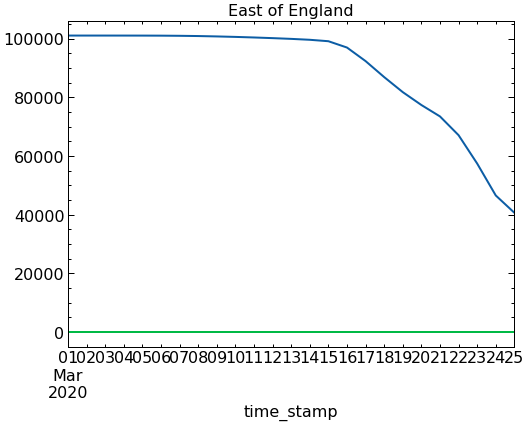

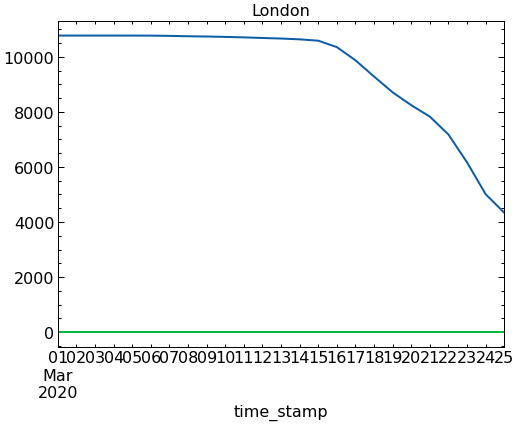

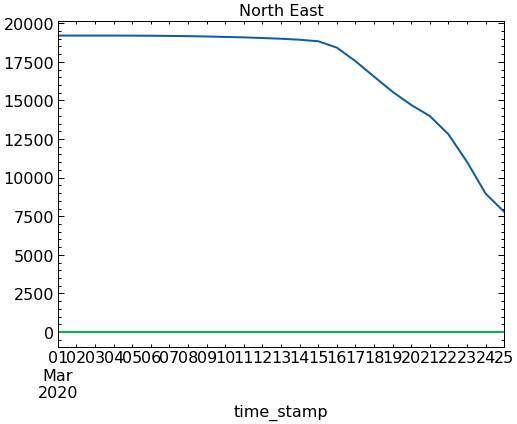

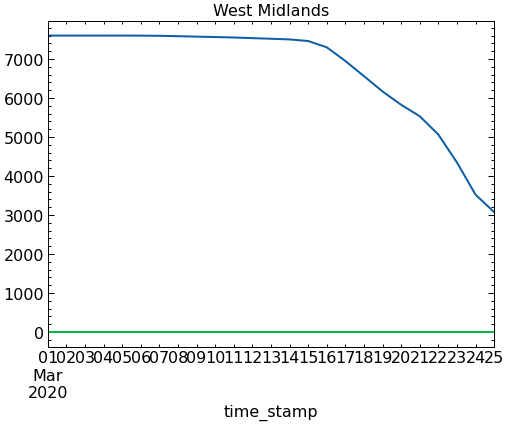

In [30]:
for region in read.regional_summary['region'].unique():
    read.regional_summary[
        read.regional_summary['region'] == region
    ]['current_infected'].plot()
    read.regional_summary[
        read.regional_summary['region'] == region
    ]['current_susceptible'].plot()
    plt.title(region)
    plt.show()

<AxesSubplot:xlabel='time_stamp'>

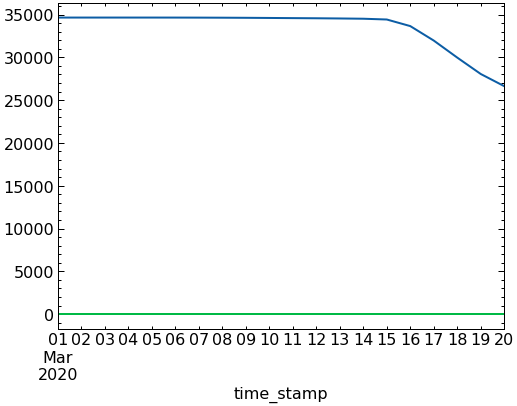

In [30]:
read.world_summary['current_infected'].plot()
read.world_summary['current_susceptible'].plot()

# Asking questions to the records

## Sero-prevalence by age

In [51]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2020-11-30 21:08:29,443 - june.records.records_reader - INFO - Loading infections table
2020-11-30 21:08:29,458 - june.records.records_reader - INFO - Loading population table
2020-11-30 21:08:29,883 - june.records.records_reader - INFO - Merging infection and population tables
2020-11-30 21:08:29,919 - june.records.records_reader - INFO - Loading geography table
2020-11-30 21:08:29,993 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [52]:
infections_df

,timestamp,location_ids,infector_ids,location_specs,region_names,age,socioeconomic_index,primary_activity_id,residence_id,area_id,sex,ethnicity,primary_activity_type,residence_type,super_area_id,name_area,region_id,name_super_area,name_region
id,,,,,,,,,,,,,,,,,,,


In [39]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2020-11-30 21:25:31,746 - june.records.records_reader - INFO - Loading deaths table
2020-11-30 21:25:31,770 - june.records.records_reader - INFO - Loading population table
2020-11-30 21:25:32,790 - june.records.records_reader - INFO - Merging infection and population tables
2020-11-30 21:25:32,807 - june.records.records_reader - INFO - Loading geography table
2020-11-30 21:25:32,863 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [33]:
age_bins = (0,20,60,100)

In [34]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [40]:
people_df = read.table_to_df('population')

In [36]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

In [37]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.legend()

KeyError: 10

## Compare to health index

In [35]:
from june.demography import Person

ages = np.arange(100)
male_death_rate_home, female_death_rate_home = [], []
male_death_rate_hospital, female_death_rate_hospital = [], []

for age in ages:
    male = Person.from_attributes(age=age, sex="m")
    female = Person.from_attributes(age=age, sex="f")
    #care_home.add(male)
    #care_home.add(female)
    male_probabilities = np.diff(
        selector.health_index_generator(male), prepend=0, append=1
    )
    male_death_rate_home.append(male_probabilities[5])
    male_death_rate_hospital.append(male_probabilities[[6, 7]].sum())
    female_probabilities = np.diff(
        selector.health_index_generator(female), prepend=0, append=1
    )
    female_death_rate_home.append(male_probabilities[5])

    female_death_rate_hospital.append(female_probabilities[[ 6, 7]].sum())

In [41]:
deaths_gp = deaths_df[deaths_df['residence_type']=='household']

In [42]:
deaths_gp[deaths_gp['location_specs'] == 'hospital'].groupby('age').size()

age
35      1
40      1
41      1
42      2
44      1
45      1
46      1
47      5
49      1
51      3
52      1
53      1
54      2
55      7
56      2
57      5
58      2
59      1
60      7
61      6
62      3
63      4
64      8
65     11
66     20
67     19
68     14
69     12
70     33
71     35
72     37
73     33
74     45
75     71
76     63
77     44
78     47
79     53
80    117
81    136
82    108
83    107
84    108
85    169
86    170
87    150
88    140
89    155
90    197
91    234
92    204
93    192
94    204
95    188
96    211
97    210
98    183
99    188
dtype: int64

In [43]:
hospital_dr = deaths_gp[deaths_gp['location_specs'] == 'hospital'].groupby(['sex','age']).size()/people_df.groupby(['sex','age']).size()

In [44]:
people_df.groupby(['sex','age']).size()

sex  age
f    0      677
     1      748
     2      721
     3      675
     4      680
           ... 
m    95     632
     96     703
     97     693
     98     700
     99     693
Length: 200, dtype: int64

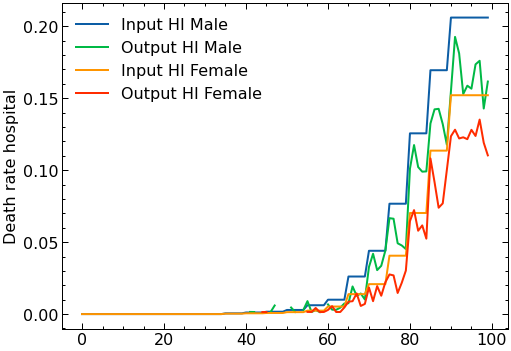

In [45]:
plt.plot(ages,male_death_rate_hospital, label='Input HI Male')
plt.plot(ages,hospital_dr.loc['m'], label='Output HI Male')

plt.plot(ages,female_death_rate_hospital, label='Input HI Female')
plt.plot(ages,hospital_dr.loc['f'], label='Output HI Female')

plt.ylabel('Death rate hospital')
plt.legend()

In [ ]:
plt.plot(ages,male_death_rate_hospital, label='Input HI Male')
plt.plot(ages,hospital_dr.loc['m'], label='Output HI Male')

plt.plot(ages,female_death_rate_hospital, label='Input HI Female')
plt.plot(ages,hospital_dr.loc['f'], label='Output HI Female')

plt.ylabel('Death rate hospital')
plt.legend()

## Care home deaths in hospital

In [38]:
care_home_deaths_hospital = deaths_df[
    (deaths_df['location_specs'] == 'hospital') 
    & (deaths_df['residence_type'] == 'care_home')
]
care_home_deaths_hospital=care_home_deaths_hospital.groupby(
    ['name_region', 'timestamp']
).size()

<AxesSubplot:xlabel='timestamp'>

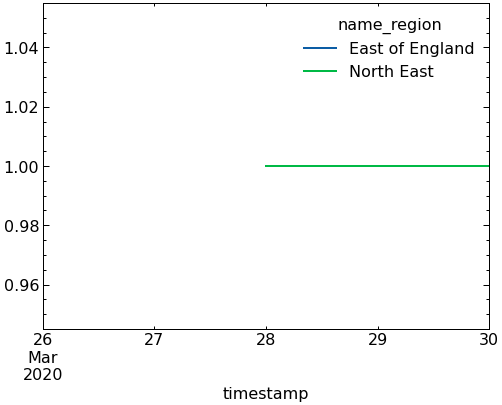

In [39]:
care_home_deaths_hospital.unstack(level=0).plot()


## Where people get infected as a function of time

In [40]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

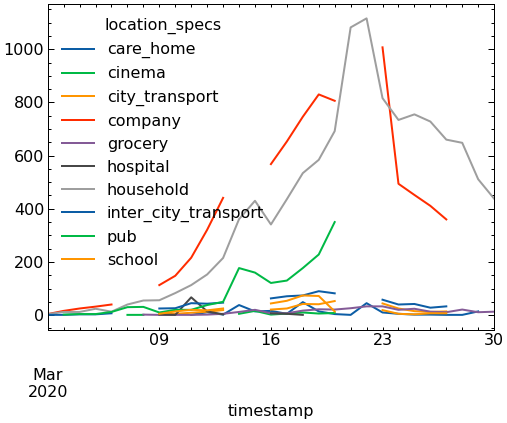

In [41]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

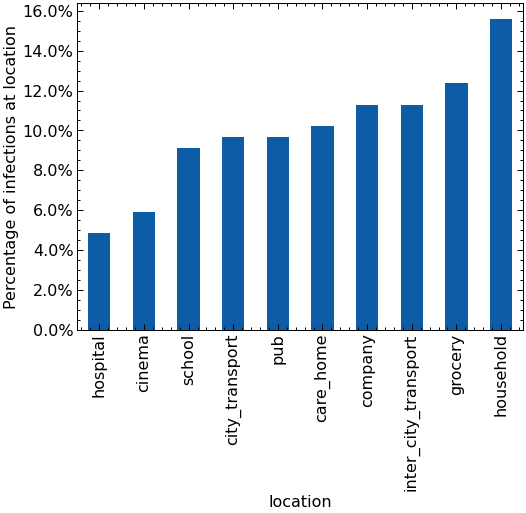

In [42]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')


## Where people of certain age get infected as a function of time

In [43]:
old_locations_df = infections_df[
    infections_df.age > 65
].groupby(['location_specs', 'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

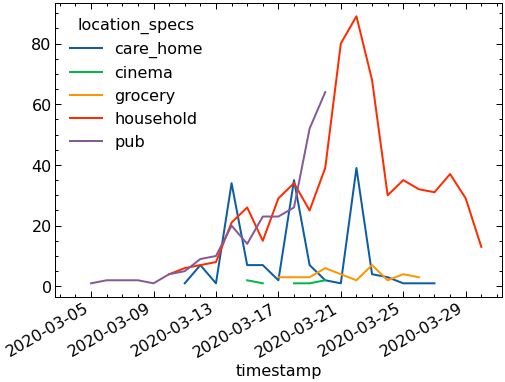

In [44]:
old_locations_df.unstack(level=0).plot()

## Prevalence by household size

In [45]:
household_people = people_df[
    people_df['residence_type'] == 'household'
]

In [46]:
household_sizes = household_people.groupby('residence_id').size()

<AxesSubplot:>

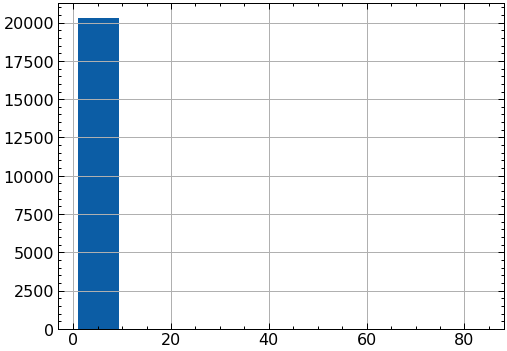

In [47]:
household_sizes.hist() # in units of households

In [48]:
household_people.loc[:,'household_size'] = household_sizes.loc[
    household_people['residence_id']
].copy(deep=True).values

/home/florpi/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/florpi/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:>

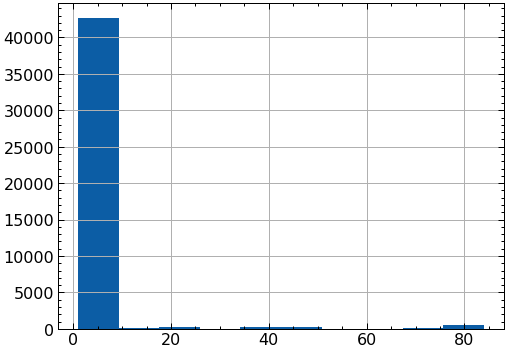

In [49]:
household_people['household_size'].hist() # in units of people

In [50]:
household_infections_df = infections_df.merge(
    household_people['household_size'], 
    left_index=True, right_index=True, how='inner'
)

(0.0, 8.0)

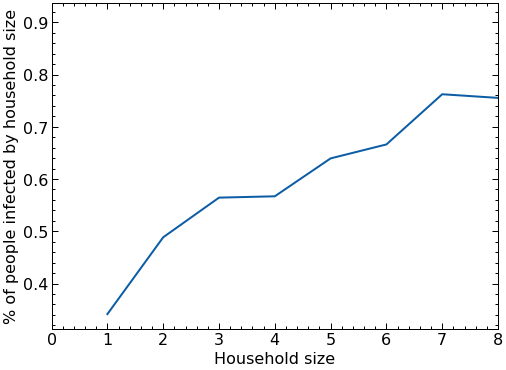

In [51]:
(household_infections_df.groupby(
    'household_size'
).size()/household_people.groupby('household_size').size()).plot()
plt.xlabel('Household size')
plt.ylabel('% of people infected by household size')
plt.xlim(0,8)

In [52]:
# How many households have everyone infected?

In [53]:
n_infected_by_household = infections_df[
    infections_df['residence_type'] == 'household'
].groupby('residence_id').size()

In [54]:
n_total_in_household = household_people[
    household_people['residence_id'].isin(
        n_infected_by_household.index
    )
].groupby('residence_id').size()

Text(0.5, 0, '% of the household infected')

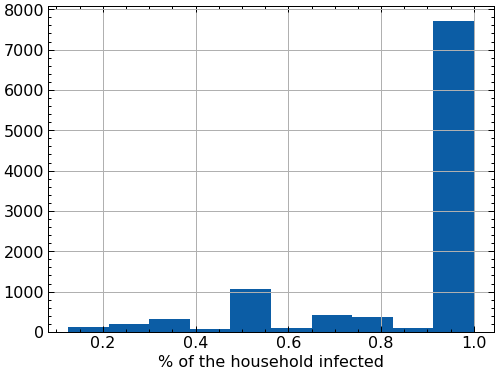

In [55]:
(n_infected_by_household/n_total_in_household).hist()
plt.xlabel('% of the household infected')

## Percentage of infected per care home

In [56]:
n_infected_by_carehome = infections_df[
    infections_df['residence_type'] == 'care_home'
].groupby(
    'residence_id'
).size()

In [57]:
n_total_in_carehome = people_df[
    (people_df['residence_type'] == 'care_home') 
    & (people_df['residence_id'].isin(n_infected_by_carehome.index))  
].groupby('residence_id').size()

Text(0.5, 0, '% of the care home infected')

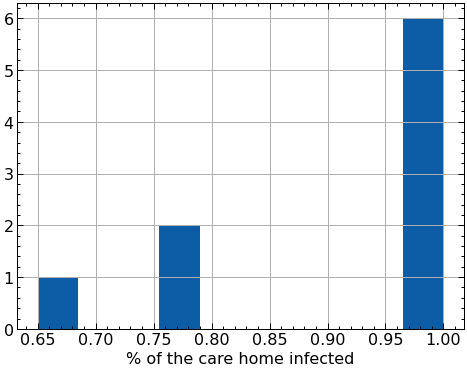

In [58]:
(n_infected_by_carehome/n_total_in_carehome).hist()
plt.xlabel('% of the care home infected')

In [59]:
# from all care homes, how many got at least one case?

In [60]:
n_total_care_homes = people_df[
    (people_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [61]:
n_total_care_homes

14

In [62]:
care_homes_with_infected = infections_df[
    (infections_df['residence_type'] == 'care_home') 
]['residence_id'].nunique()

In [63]:
care_homes_with_infected/n_total_care_homes

0.6428571428571429